In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numexpr as ne
import time
import copy
import sys

from tqdm import tqdm
from sklearn.metrics import accuracy_score, log_loss

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../pytorch_utils/')
from utils import train, evaluate, get_data, top5_accuracy, per_class_accuracy, count_params

In [3]:
import torch.cuda
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.benchmark = True

# Load data

In [5]:
%%time
X_train, X_val, Y_train, Y_val = get_data()
train_size = len(X_train)
val_size = len(X_val)
print(train_size, val_size)

51200 5120
CPU times: user 1min 31s, sys: 10.4 s, total: 1min 42s
Wall time: 40.6 s


# Create iterators

In [6]:
val_data = TensorDataset(
    torch.FloatTensor(X_val), 
    torch.LongTensor(Y_val)
)

val_iterator = DataLoader(
    val_data, batch_size=64, shuffle=True, pin_memory=True
)

In [7]:
batch_size = 64

In [8]:
train_data = TensorDataset(
    torch.FloatTensor(X_train), 
    torch.LongTensor(Y_train)
)

train_iterator = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Model

In [9]:
from model_inception import make_model

In [10]:
model, criterion, optimizer = make_model()

In [11]:
count_params(model)

22310112

# Train

In [12]:
n_epochs = 2
validation_step = 200
n_batches = int(np.ceil(train_size/batch_size))
M = 1
T = n_batches*n_epochs
initial = 0.01
n_batches

800

In [13]:
def lr_scheduler(optimizer, step):
    
    global initial
    decay = np.cos(np.pi*((step - 1) % (T // M))/(T // M)) + 1.0
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = initial*decay/2.0
    
    if (step - 1) % (T // M) == 0 and step != 1:
        # initial *= 0.5
        print('lr is reset:', initial)
        
    return optimizer

In [14]:
all_losses = []
all_models = []

In [15]:
%%time
running_loss = 0.0
running_accuracy = 0.0 
start = time.time()
model.train()

for epoch in range(0, n_epochs):
    for step, (x_batch, y_batch) in enumerate(train_iterator, 1 + epoch*n_batches):
        
        optimizer = lr_scheduler(optimizer, step)
        batch_loss, batch_accuracy = train(
            model, criterion, optimizer, 
            x_batch, y_batch
        )
        running_loss += batch_loss
        running_accuracy += batch_accuracy
        
        if step % validation_step == 0:
            model.eval()
            test_loss, test_accuracy = evaluate(
                model, criterion, val_iterator
            )
            end = time.time()
            
            print('{0:.2f}  {1:.3f} {2:.3f}  {3:.3f} {4:.3f}  {5:.3f}'.format(
                step/n_batches, running_loss/validation_step, test_loss, 
                running_accuracy/validation_step, test_accuracy, end - start
            ))
            all_losses += [(
                step/n_batches,
                running_loss/validation_step, test_loss, 
                running_accuracy/validation_step, test_accuracy
            )] 
            
            running_loss = 0.0
            running_accuracy = 0.0 
            start = time.time()
            model.train()
            
        if step % (T // M) == 0:
            
            print('saving')
            model.cpu()
            clone = copy.deepcopy(model)
            all_models += [clone.state_dict()]
            model.cuda()

0.25  4.018 2.516  0.409 0.666  78.135
0.50  2.288 1.761  0.683 0.750  76.997
0.75  1.867 1.501  0.719 0.765  77.376
1.00  1.671 1.475  0.746 0.761  77.304
1.25  1.520 1.399  0.777 0.767  77.284
1.50  1.522 1.426  0.774 0.761  77.306
1.75  1.470 1.414  0.786 0.771  77.318
2.00  1.488 1.475  0.778 0.762  77.293
saving
CPU times: user 8min 9s, sys: 2min 8s, total: 10min 17s
Wall time: 10min 19s


# Loss/epoch

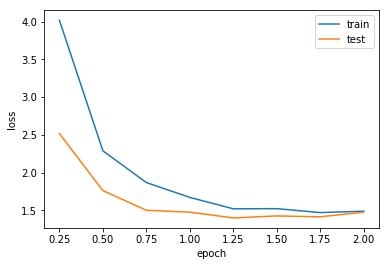

In [16]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='test');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

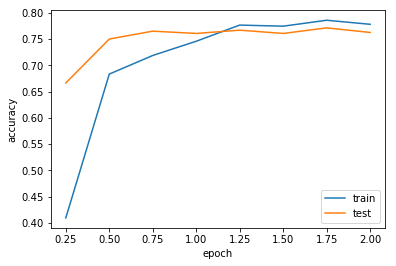

In [17]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='test');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

# Predict val. set

In [18]:
val_predictions = []

In [19]:
val_iterator_no_shuffle = DataLoader(
    val_data, batch_size=64, shuffle=False, pin_memory=True
)

In [20]:
%%time
# model.load_state_dict(all_models[-1])
model.eval()

for x_batch, _ in val_iterator_no_shuffle:

    x_batch = Variable(x_batch.cuda(), volatile=True)
    logits = model(x_batch)

    # compute probabilities
    probs = F.softmax(logits) 
    val_predictions += [probs.cpu().data.numpy()]

CPU times: user 20.2 s, sys: 5.44 s, total: 25.7 s
Wall time: 25.7 s


In [21]:
val_predictions = np.concatenate(val_predictions, axis=0)

In [43]:
accuracy_score(Y_val, val_predictions.argmax(1))

0.76640624999999996

In [44]:
log_loss(Y_val, val_predictions)

1.4334521167143677

In [45]:
top5_accuracy(Y_val, val_predictions)

0.91425781250000004

In [55]:
per_class_acc = per_class_accuracy(Y_val, val_predictions)
per_class_acc

array([ 0.85,  0.75,  0.8 ,  0.65,  0.55,  0.75,  0.55,  0.8 ,  0.95,
        0.8 ,  1.  ,  0.95,  0.65,  0.9 ,  0.95,  0.6 ,  0.6 ,  0.65,
        0.8 ,  0.8 ,  0.75,  0.95,  1.  ,  0.9 ,  0.5 ,  0.4 ,  0.95,
        0.8 ,  0.9 ,  0.5 ,  0.7 ,  0.65,  0.55,  0.95,  0.75,  0.85,
        0.75,  0.75,  0.35,  0.8 ,  0.95,  0.5 ,  0.7 ,  0.75,  0.85,
        0.85,  0.95,  0.85,  1.  ,  0.75,  0.8 ,  0.7 ,  0.95,  0.75,
        0.45,  0.65,  1.  ,  0.65,  0.25,  0.7 ,  0.75,  0.85,  0.85,
        0.9 ,  0.85,  0.95,  0.85,  0.9 ,  0.7 ,  0.6 ,  0.5 ,  1.  ,
        0.65,  0.45,  0.65,  0.9 ,  0.95,  0.65,  0.45,  0.5 ,  0.85,
        0.65,  0.8 ,  0.8 ,  0.55,  0.8 ,  0.85,  0.75,  0.8 ,  0.95,
        0.95,  0.85,  0.9 ,  0.95,  0.8 ,  0.45,  0.65,  0.95,  0.65,
        0.85,  0.95,  0.75,  0.95,  0.8 ,  0.7 ,  0.75,  0.95,  0.7 ,
        0.9 ,  0.9 ,  0.9 ,  0.7 ,  0.9 ,  0.95,  0.75,  0.75,  0.85,
        0.65,  0.75,  0.75,  0.95,  0.75,  0.95,  0.85,  0.45,  0.45,
        0.95,  0.75,

# Error analysis

In [56]:
erroneous = Y_val != val_predictions.argmax(1)
n_errors = len(Y_val[erroneous])
n_errors

1196

In [57]:
to_show = np.random.choice(np.arange(0, n_errors), size=30, replace=False)

In [58]:
pictures = X_val[erroneous][to_show].copy()
pictures_predictions = val_predictions.argmax(1)[erroneous][to_show]
pictures_probs = val_predictions.max(1)[erroneous][to_show]
pictures_true = Y_val[erroneous][to_show]

In [59]:
mean = np.array([0.485, 0.456, 0.406], dtype='float32')
std = np.array([0.229, 0.224, 0.225], dtype='float32')
decode = np.load('../utils/decode.npy')[()]

In [60]:
pictures = np.transpose(pictures, axes=(0, 2, 3, 1))
ne.evaluate('pictures*std', out=pictures);
ne.evaluate('pictures + mean', out=pictures);

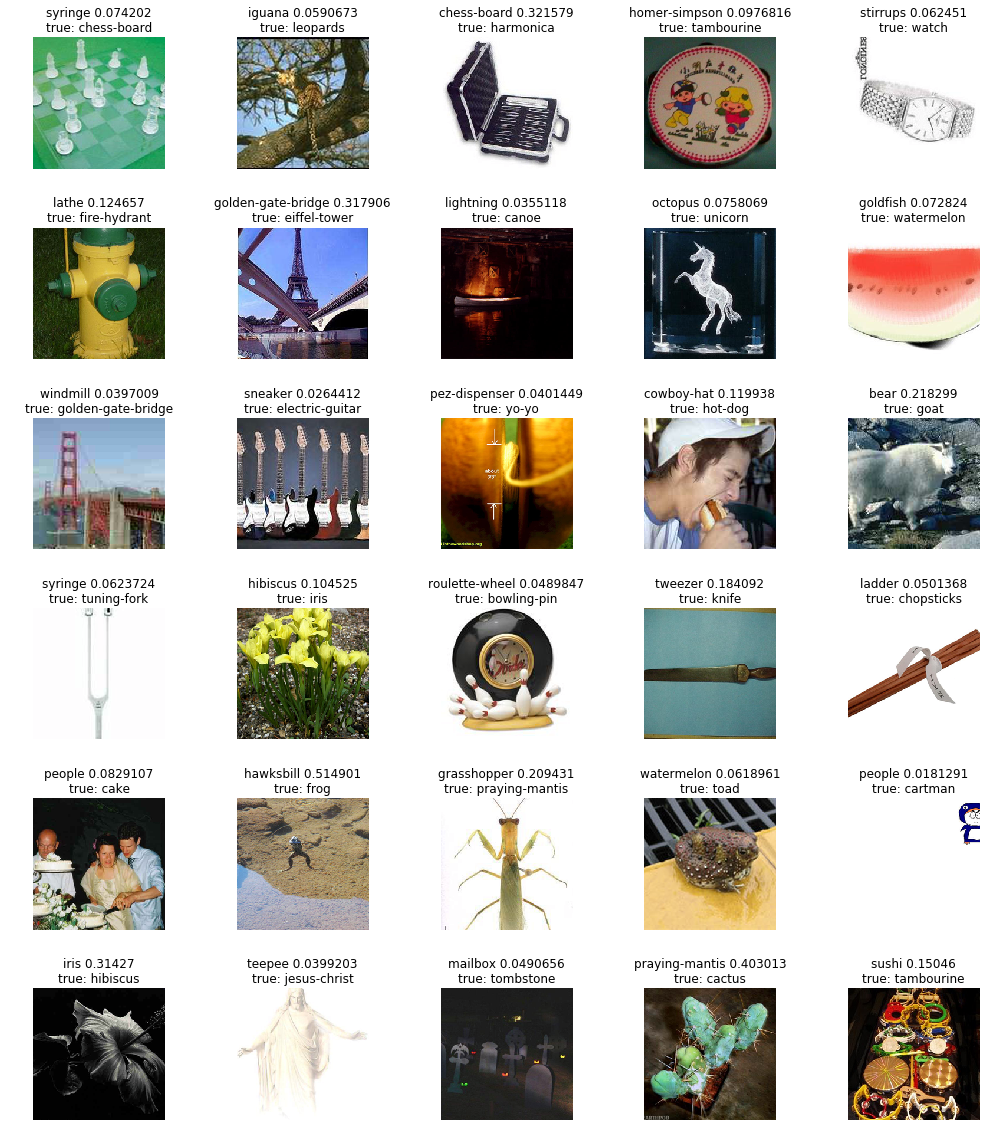

In [64]:
# show pictures, predicted classes and probabilities
_, axes = plt.subplots(nrows=6, ncols=5, figsize=(14, 16))
axes = axes.flatten()
for i, pic in enumerate(pictures):
    axes[i].set_axis_off();
    axes[i].imshow(pic);
    title = decode[pictures_predictions[i] + 1] + ' ' +\
        str(pictures_probs[i]) + '\ntrue: ' + decode[pictures_true[i] + 1]
    axes[i].set_title(title);
plt.tight_layout()

# Save the model

In [65]:
for i, m in enumerate(all_models):
    torch.save(m, 'model_state' + str(i) + '.pytorch')